In [1]:
import numpy as np
import math

import matplotlib.pyplot as plt
import cartopy.crs as crs
import cartopy.feature as cfeature
import matplotlib.colors as colors
from matplotlib.cm import get_cmap
from matplotlib import ticker
import matplotlib.gridspec as gridspec

from cartopy import config
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.util import add_cyclic_point

from IPython.display import Image

from tqdm import tqdm
import os 

In [2]:
Years = ["2000","2001","2002"]

Months = []
for imon in range(1,13): ### shw
    Months.append(str(imon).zfill(2))
    
Days = []
for iday in range(1,30,3):
    Days.append(str(iday).zfill(2))
    
print(Years)
print(Months)
print(Days)

['2000', '2001', '2002']
['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
['01', '04', '07', '10', '13', '16', '19', '22', '25', '28']


In [3]:
N_head = 5 # first 5 lines are head lines, not include data
N_column = 4+2

Nx = 36
Ny = 21
Nz = 5
N_parcel = 3780

if Nx*Ny*Nz!=N_parcel: print('ERROR: parcel number is wrong!')
    

directory = '/n/home12/hongwei/HONGWEI/lagranto.era5/Simulation/Python_plot/Lifetime_'+Years[0]+'/'
filename = "Lifetime_"+Years[0]+Months[0]+Days[0]+".txt"
print(directory+filename)

/n/home12/hongwei/HONGWEI/lagranto.era5/Simulation/Python_plot/Lifetime_2000/Lifetime_20000101.txt


In [4]:
N_year  = len(Years)
N_month = len(Months)
N_day   = len(Days)

lifetime = np.zeros((Nz, Ny, Nx, N_day, N_month, N_year))
lifetime.shape

(5, 21, 36, 10, 12, 3)

In [5]:
for i_year in range(N_year):
    for i_month in tqdm(range(N_month)):
        for i_day in range(N_day):
            directory = '/n/home12/hongwei/HONGWEI/lagranto.era5/Simulation/Python_plot/Lifetime_'+Years[i_year]+'/'
            filename = "Lifetime_"+Years[i_year]+Months[i_month]+Days[i_day]+".txt"
            File = open(directory+filename, 'r')
        
            Lines = File.readlines()

            # Strips the newline character
            data = []
            data_N = []
            for line in Lines:
                a = line.split(',')
                data.append(float(a[0])) # total lifetime
#                 data_N.append(float(a[1]))
#                 data_S.append(float(a[2]))
    
    
            i = 0
            for ix in range(Nx):
                for iy in range(Ny):
                    for iz in range(Nz):
                        lifetime[iz,iy,ix,i_day,i_month,i_year] = data[i]
                        
                        i = i+1
                        

100%|██████████| 12/12 [00:05<00:00,  2.06it/s]


In [6]:
# lifetime # [Nz, Ny, Nx, N_day, N_month, N_year]
print(Ny*Nx*N_day*N_month*N_year)

272160


In [7]:

lifetime_mean = np.mean(lifetime, axis=(1,2,3,4,5))
lifetime_max  = np.max(lifetime, axis=(1,2,3,4,5))


# Life_Q1 = np.zeros(5)
# Life_90th = np.zeros(5)
# Life_99th = np.zeros(5)

# for i in range(Nz):
#     Life_Q1[i] = np.percentile(Life[i,:,:,:,:].flatten(), 25)  # Q1
#     Life_90th[i] = np.percentile(lifetime[i,:,:,:,:,:].flatten(), 99)  # Q1
#     Life_99th[i] = np.percentile(lifetime[i,:,:,:,:,:].flatten(), 99.9)  # Q1
    
    
    
# 10mean
Life_top = np.zeros(5)

for i in range(Nz):
    a = lifetime[i,:,:,:,:,:].flatten()
    a.sort()
    Num = int(len(a)*0.05)
    Life_top[i] = np.mean(a[-Num:-1])

print(Life_top)

print(0.001*Ny*Nx*N_day*N_month*N_year)

[1431.38700669 2416.78937312 2815.39332696 2861.0934813  2875.11890938]
272.15999999999997


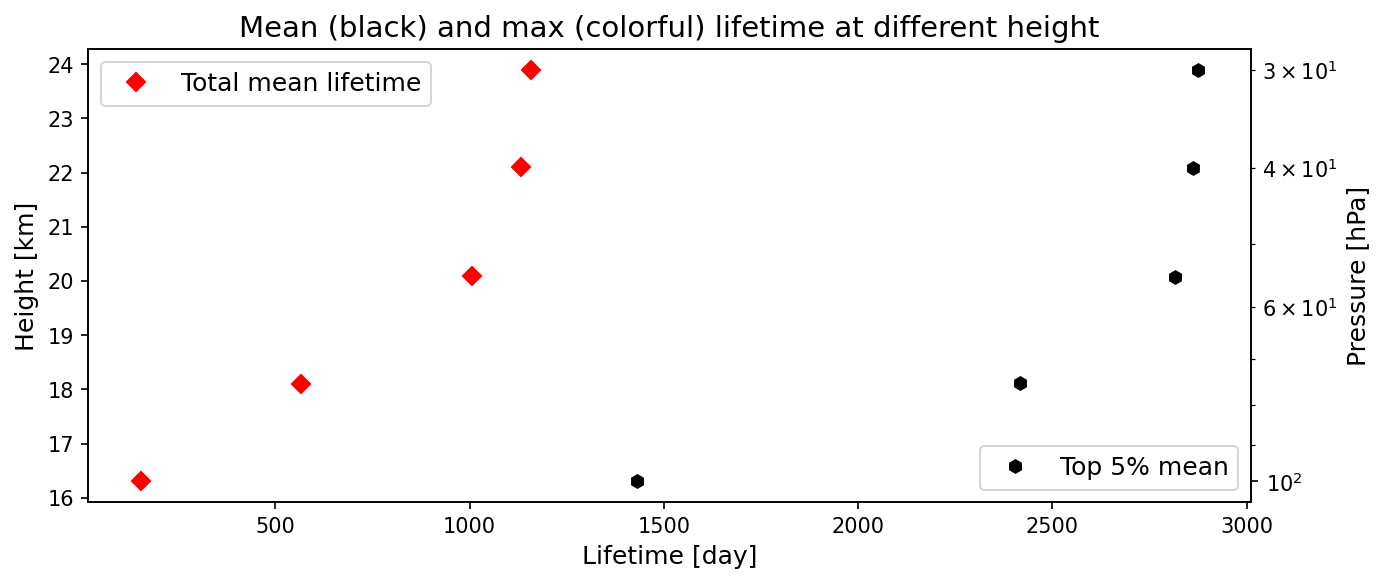

In [8]:
# total average lifetime at different altitude
# plus max lifetime data point at different altitude

Pressure = [100, 75, 55, 40, 30] # hPa
Height = [16.3, 18.1, 20.1, 22.1, 23.9] # km

fig, ax1 = plt.subplots(figsize=(10,4), dpi=150)

ax2 = ax1.twinx()

ax1.plot(lifetime_mean, Height, 'rD', label='Total mean lifetime')

ax1.set_xlabel('Lifetime [day]', fontsize=12)
ax1.set_ylabel('Height [km]', fontsize=12)


#
ax2.plot(Life_top, Pressure, 'kh', label='Top 5% mean')
# ax2.plot(Life_99th, Pressure, 'bx', label='99.9th percentile')
# ax2.plot(Life_90th, Pressure, 'k*', label='99th precentile')


ax2.set_ylabel('Pressure [hPa]', fontsize=12)
ax2.set_yscale('log')
ax2.invert_yaxis()

ax1.legend(loc='upper left', fontsize=12);
ax2.legend(loc="lower right", fontsize=12);

plt.title('Mean (black) and max (colorful) lifetime at different height', fontsize=14);

# plt.legend();

1. Average lifetime is very different from the max/99.9 percentile lifetime, which means we can achieve a much longer lifetime by selecting injection location (lon, lat) and time.

2. Injection at 18 to 24 km have similar max/99.9 percentile lifetime, which means we can achieve similar longest lifetime by injecting at lower altitude.

In [9]:
# David's figure

# lifetime # [Nz, Ny, Nx, N_day, N_month, N_year]

lifetime_mean = np.mean(lifetime, axis=(1,2,3,4,5))

# Top 10% mean: calculate top 10% mean for each month in each year at each injection height
Life_top = np.zeros((Nz, N_month, N_year))

lifetime_MonMean = np.mean(lifetime, axis=3)
print("lifetime_MonMean.shape:", lifetime_MonMean.shape)

for iz in range(Nz):
    for imon in range(N_month):
        for iyr in range(N_year):
            a = lifetime_MonMean[iz,:,:,imon,iyr].flatten()
            a.sort()
            Num = int(len(a)*0.1)
            Life_top[iz,imon,iyr] = np.mean(a[-Num:-1])

print("Life_top.shape: ", Life_top.shape)

Life_top_YearMean = np.mean(Life_top, axis=2)
Life_Z_TopMean = np.mean(Life_top, axis=(1,2))

lifetime_MonMean.shape: (5, 21, 36, 12, 3)
Life_top.shape:  (5, 12, 3)


[ 1  2  3  4  5  6  7  8  9 10 11 12]


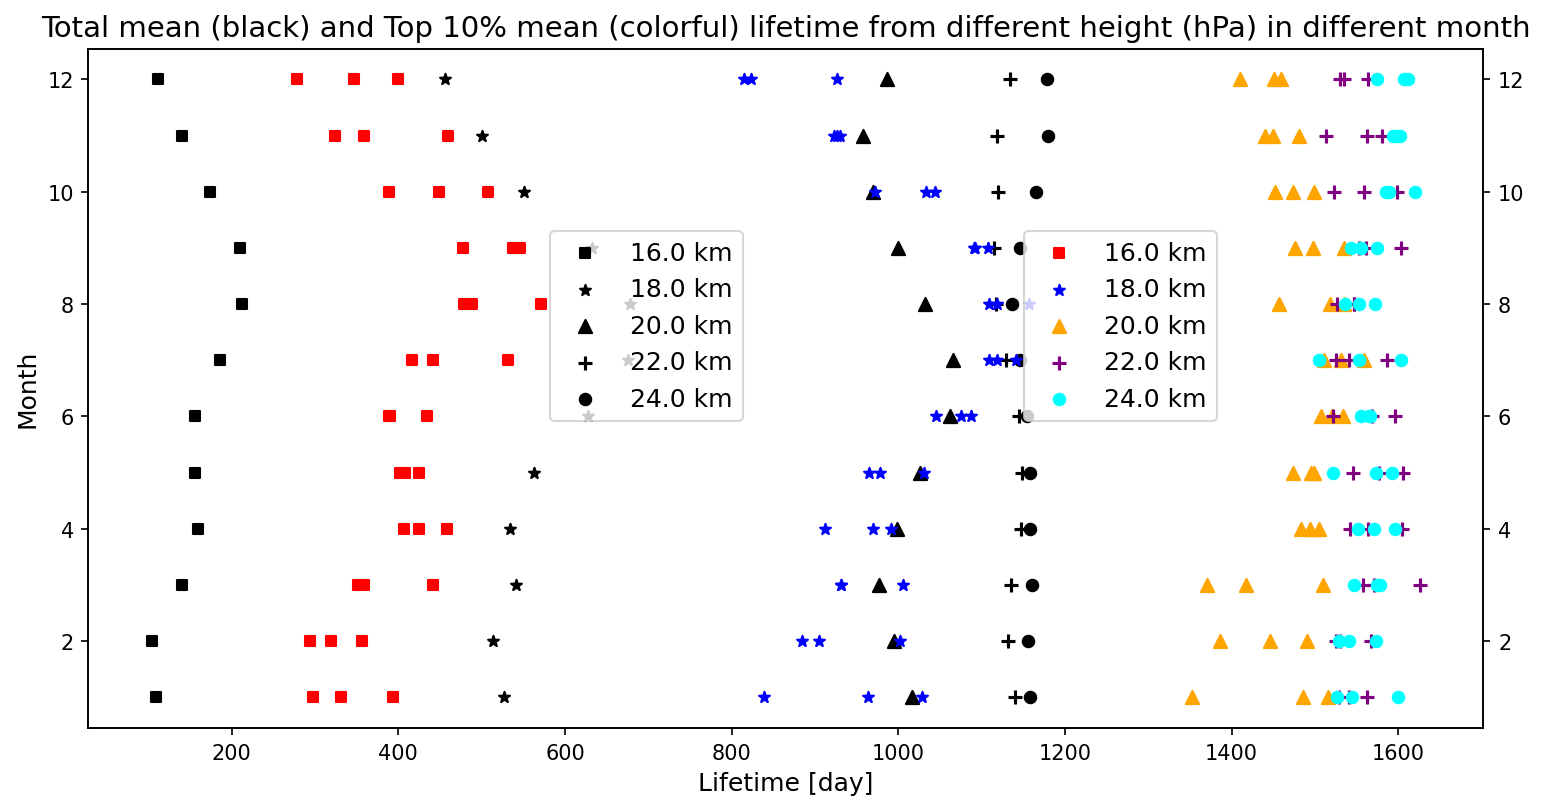

In [10]:
lifetime_z_month_mean = np.mean(lifetime, axis=(1,2,3,5))


Mons = np.arange(1,13,1)
print(Mons)

fig, ax1 = plt.subplots(figsize=(12,6), dpi=150)

ax2 = ax1.twinx()

colors = ['red','blue','orange','purple','cyan']
markers = ['s','*','^','+','o']
sizes = [20,30,40,50,30]


###
for i in range(Nz):
    ax1.scatter(lifetime_z_month_mean[i,:], Mons, c='k', marker=markers[i], s=sizes[i], label=f"{np.round(Height[i])} km")
#     ax2.scatter(lifetime_z_month_max[i,:], Mons, c=colors[i], marker=markers[i], s=sizes[i], label=Pressure[i])
    ax2.scatter(Life_top[i,:,0], Mons, c=colors[i], marker=markers[i], s=sizes[i], label=f"{np.round(Height[i])} km")
    ax2.scatter(Life_top[i,:,1], Mons, c=colors[i], marker=markers[i], s=sizes[i])
    ax2.scatter(Life_top[i,:,2], Mons, c=colors[i], marker=markers[i], s=sizes[i])


ax1.set_xlabel('Lifetime [day]', fontsize=12)
ax1.set_ylabel('Month', fontsize=12)


ax1.legend(loc='upper center', fontsize=12, bbox_to_anchor=(0.4, 0.75));
ax2.legend(loc="upper center", fontsize=12, bbox_to_anchor=(0.74, 0.75));

plt.title('Total mean (black) and Top 10% mean (colorful) lifetime from different height (hPa) in different month', fontsize=14);

# plt.legend();

[ 1  2  3  4  5  6  7  8  9 10 11 12]


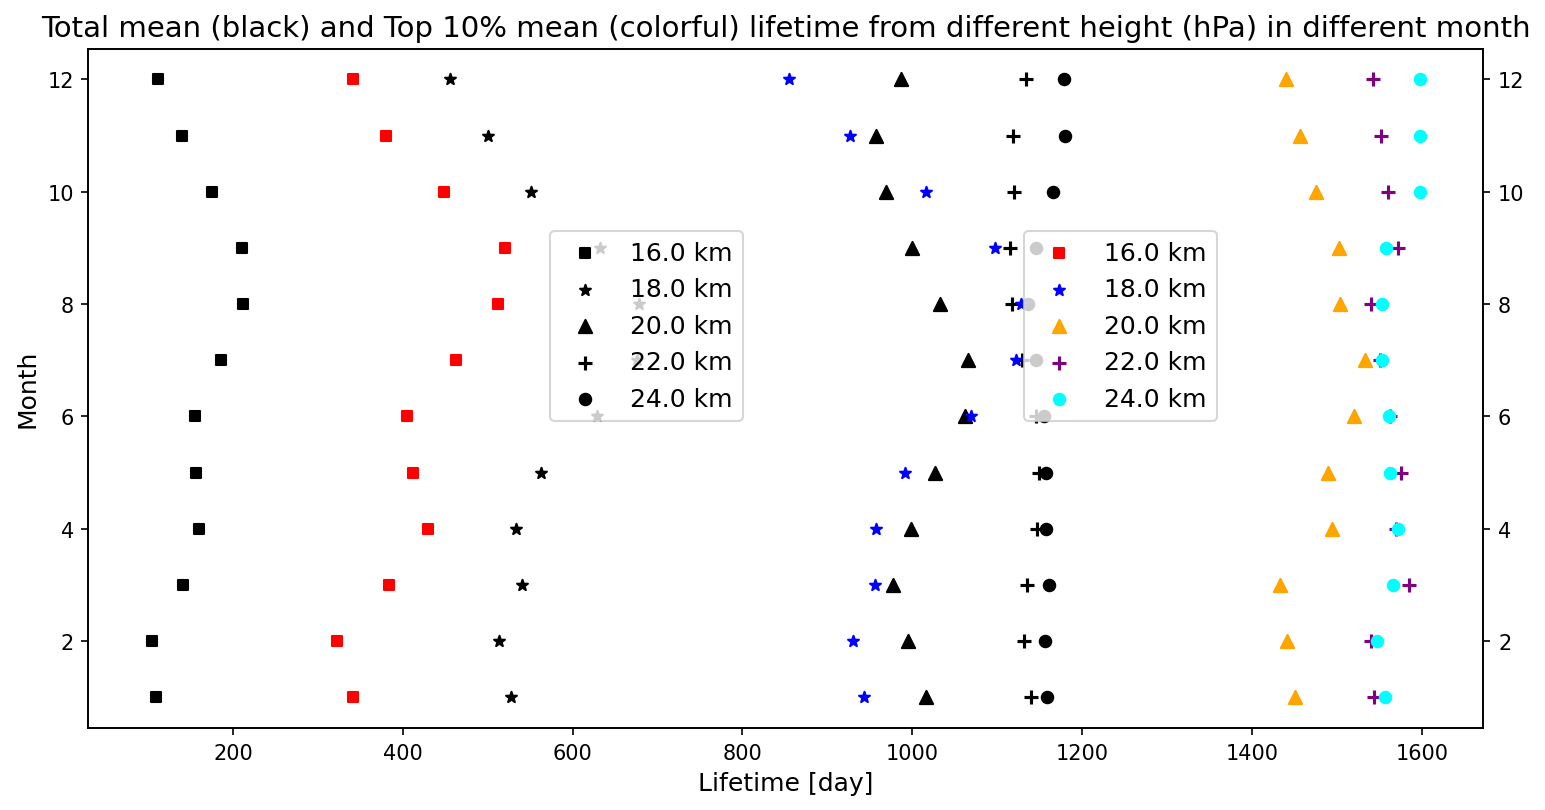

In [11]:
lifetime_z_month_mean = np.mean(lifetime, axis=(1,2,3,5))


Mons = np.arange(1,13,1)
print(Mons)

fig, ax1 = plt.subplots(figsize=(12,6), dpi=150)

ax2 = ax1.twinx()

colors = ['red','blue','orange','purple','cyan']
markers = ['s','*','^','+','o']
sizes = [20,30,40,50,30]


###
for i in range(Nz):
    ax1.scatter(lifetime_z_month_mean[i,:], Mons, c='k', marker=markers[i], s=sizes[i], label=f"{np.round(Height[i])} km")
#     ax2.scatter(lifetime_z_month_max[i,:], Mons, c=colors[i], marker=markers[i], s=sizes[i], label=Pressure[i])
    ax2.scatter(Life_top_YearMean[i,:], Mons, c=colors[i], marker=markers[i], s=sizes[i], label=f"{np.round(Height[i])} km")


ax1.set_xlabel('Lifetime [day]', fontsize=12)
ax1.set_ylabel('Month', fontsize=12)


ax1.legend(loc='upper center', fontsize=12, bbox_to_anchor=(0.4, 0.75));
ax2.legend(loc="upper center", fontsize=12, bbox_to_anchor=(0.74, 0.75));

plt.title('Total mean (black) and Top 10% mean (colorful) lifetime from different height (hPa) in different month', fontsize=14);

# plt.legend();

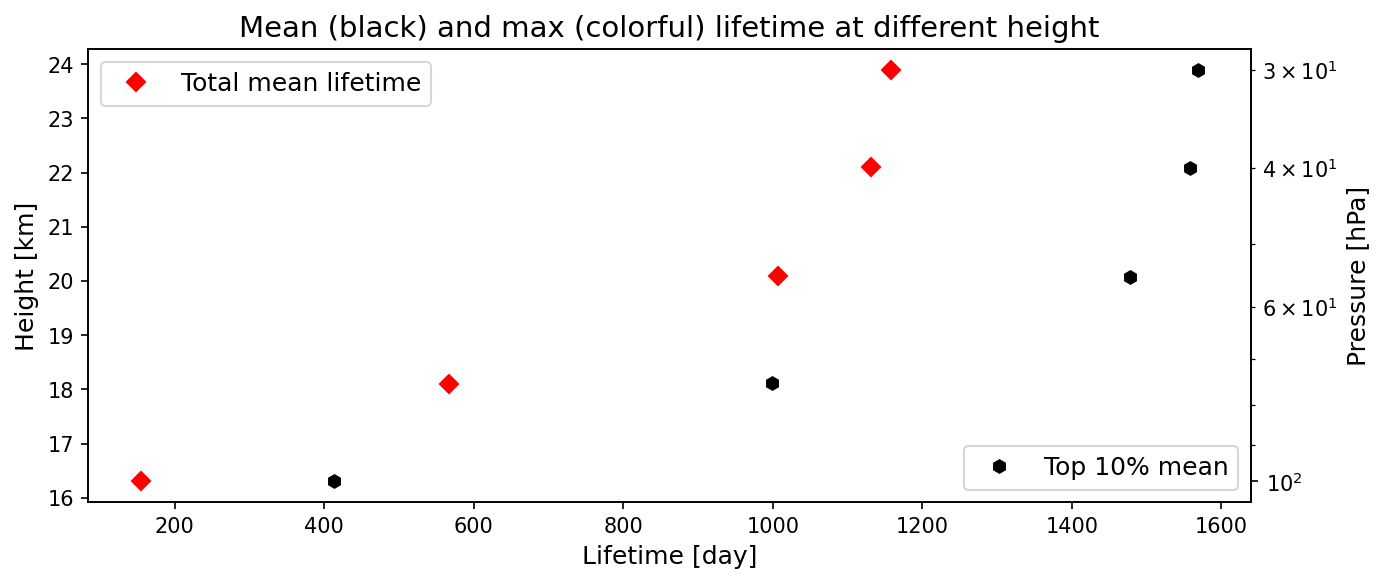

In [12]:
fig, ax1 = plt.subplots(figsize=(10,4), dpi=150)

ax2 = ax1.twinx()

ax1.plot(lifetime_mean, Height, 'rD', label='Total mean lifetime')

ax1.set_xlabel('Lifetime [day]', fontsize=12)
ax1.set_ylabel('Height [km]', fontsize=12)


#
ax2.plot(Life_Z_TopMean, Pressure, 'kh', label='Top 10% mean')
# ax2.plot(Life_99th, Pressure, 'bx', label='99.9th percentile')
# ax2.plot(Life_90th, Pressure, 'k*', label='99th precentile')


ax2.set_ylabel('Pressure [hPa]', fontsize=12)
ax2.set_yscale('log')
ax2.invert_yaxis()

ax1.legend(loc='upper left', fontsize=12);
ax2.legend(loc="lower right", fontsize=12);

plt.title('Mean (black) and max (colorful) lifetime at different height', fontsize=14);

In [13]:
# for different lat
# lifetime # [Nz, Ny, Nx, N_day, N_month, N_year]

lifetime_z_lat_mean = np.mean(lifetime, axis=(2,3,4,5))
lifetime_z_lat_max = np.max(lifetime, axis=(2,3,4,5))

print(lifetime_z_lat_mean.shape)



# Life_lat_99th = np.zeros((Nz,Ny))

# for i in range(Nz):
#     for j in range(Ny):
#         Life_lat_99th[i,j] = np.percentile(lifetime[i,j,:,:,:,:].flatten(), 99.9)  # Q1
        
        
# 10mean
Life_lat_top = np.zeros((Nz,Ny))

for iz in range(Nz):
    for iy in range(Ny):
        a = lifetime[iz,iy,:,:,:,:].flatten()
        a.sort()
        Num = int(len(a)*0.05)
        Life_lat_top[iz,iy] = np.mean(a[-Num:-1])

print(Life_10mean)

(5, 21)


NameError: name 'Life_10mean' is not defined

In [ ]:
Pressure = [100, 75, 55, 40, 30] # hPa
Height = [16.3, 18.1, 20.1, 22.1, 23.9] # km
Lats = np.arange(-20,21,2)
print(Lats)

fig, ax1 = plt.subplots(figsize=(12,6), dpi=150)

ax2 = ax1.twinx()

colors = ['red','blue','orange','purple','cyan']
markers = ['s','*','^','+','o']
sizes = [20,30,40,50,30]


###
for i in range(Nz):
    ax1.scatter(lifetime_z_lat_mean[i,:], Lats, c='k', marker=markers[i], s=sizes[i], label=f"{np.round(Height[i])} km")
#     ax2.scatter(lifetime_z_lat_max[i,:], Lats, c=colors[i], marker=markers[i], s=sizes[i], label=Pressure[i])
    ax2.scatter(Life_lat_top[i,:], Lats, c=colors[i], marker=markers[i], s=sizes[i], label=f"{np.round(Height[i])} km")


ax1.set_xlabel('Lifetime [day]', fontsize=12)
ax1.set_ylabel('Lat [deg]', fontsize=12)


ax1.legend(loc='upper center', fontsize=12, bbox_to_anchor=(0.5, 1));
ax2.legend(loc="upper center", fontsize=12, bbox_to_anchor=(0.5, 0.32));

plt.title('Total mean(black) and Top 5% mean(colorful) lifetime from different height (hPa) at different latitude', fontsize=14);

# plt.legend();

In [ ]:
# for different lat
# lifetime[Nz, Ny, Nx, N_day, N_month, N_year]

lifetime_z_lat_mon_mean = np.mean(lifetime, axis=(2,3,5))
lifetime_z_lat_mon_max = np.max(lifetime, axis=(2,3,5))

print(lifetime_z_lon_mon_mean.shape)



# Life_lon_99th = np.zeros((Nz,Nx,N_month))

# for i in range(Nz):
#     for j in range(Nx):
#         for k in range(N_month):
#             Life_lon_99th[i,j,k] = np.percentile(lifetime[i,:,j,:,k,:].flatten(), 99.9)  # Q1
        
        
# 10mean
Life_lat_mon_top = np.zeros((Nz,Ny,N_month))

for iz in range(Nz):
    for iy in range(Ny):
        for imon in range(N_month):
            a = lifetime[iz,:,iy,:,imon,:].flatten()
            a.sort()
            Num = int(len(a)*0.05)
            Life_lat_mon_top[iz,iy,imon] = np.mean(a[-Num:-1])

In [ ]:
Pressure = [100, 75, 55, 40, 30] # hPa
Height = [16.3, 18.1, 20.1, 22.1, 23.9] # km
Lons = np.arange(0,360,10)
print(Lons)

fig, ax1 = plt.subplots(figsize=(12,6), dpi=150)

# ax2 = ax1.twinx()

colors = ['red','blue','orange','purple','cyan']
markers = ['s','*','^','+','o']
sizes = [20,30,40,50,30]


###
for i in range(Nz):
    ax1.scatter(lifetime_z_lat_mon_mean[i,:,0], Lats, \
                c='k', marker=markers[i], s=sizes[i], label=f"{np.round(Height[i])} km")
#     ax2.scatter(Life_lon_mon_top[i,:,0], Lons, \
#                 c=colors[i], marker=markers[i], s=sizes[i], label=Pressure[i])

    
ax1.set_xlabel('Lifetime [day]', fontsize=12)
ax1.set_ylabel('Lat [deg]', fontsize=12)


ax1.legend(loc='upper center', fontsize=12, bbox_to_anchor=(0.42, 0.3));

plt.title('Jan: Mean lifetime from different height (hPa) at different lat', fontsize=14);

In [ ]:
Pressure = [100, 75, 55, 40, 30] # hPa
Height = [16.3, 18.1, 20.1, 22.1, 23.9] # km
Lons = np.arange(0,360,10)
print(Lons)

fig, ax1 = plt.subplots(figsize=(12,6), dpi=150)

# ax2 = ax1.twinx()

colors = ['red','blue','orange','purple','cyan']
markers = ['s','*','^','+','o']
sizes = [20,30,40,50,30]


###
for i in range(Nz):
    ax1.scatter(lifetime_z_lat_mon_mean[i,:,3], Lats, \
                c='k', marker=markers[i], s=sizes[i], label=f"{np.round(Height[i])} km")
#     ax2.scatter(Life_lon_mon_top[i,:,0], Lons, \
#                 c=colors[i], marker=markers[i], s=sizes[i], label=Pressure[i])

    
ax1.set_xlabel('Lifetime [day]', fontsize=12)
ax1.set_ylabel('Lat [deg]', fontsize=12)


ax1.legend(loc='upper center', fontsize=12, bbox_to_anchor=(0.42, 1));

plt.title('Apr: Mean lifetime from different height (hPa) at different lat', fontsize=14);

In [ ]:
Pressure = [100, 75, 55, 40, 30] # hPa
Height = [16.3, 18.1, 20.1, 22.1, 23.9] # km
Lons = np.arange(0,360,10)
print(Lons)

fig, ax1 = plt.subplots(figsize=(12,6), dpi=150)

# ax2 = ax1.twinx()

colors = ['red','blue','orange','purple','cyan']
markers = ['s','*','^','+','o']
sizes = [20,30,40,50,30]


###
for i in range(Nz):
    ax1.scatter(lifetime_z_lat_mon_mean[i,:,6], Lats, \
                c='k', marker=markers[i], s=sizes[i], label=f"{np.round(Height[i])} km")
#     ax2.scatter(Life_lon_mon_top[i,:,0], Lons, \
#                 c=colors[i], marker=markers[i], s=sizes[i], label=Pressure[i])

    
ax1.set_xlabel('Lifetime [day]', fontsize=12)
ax1.set_ylabel('Lat [deg]', fontsize=12)


ax1.legend(loc='upper center', fontsize=12, bbox_to_anchor=(0.42, 0.3));

plt.title('Jul: Mean lifetime from different height (hPa) at different lat', fontsize=14);

In [ ]:
Pressure = [100, 75, 55, 40, 30] # hPa
Height = [16.3, 18.1, 20.1, 22.1, 23.9] # km
Lons = np.arange(0,360,10)
print(Lons)

fig, ax1 = plt.subplots(figsize=(12,6), dpi=150)

# ax2 = ax1.twinx()

colors = ['red','blue','orange','purple','cyan']
markers = ['s','*','^','+','o']
sizes = [20,30,40,50,30]


###
for i in range(Nz):
    ax1.scatter(lifetime_z_lat_mon_mean[i,:,9], Lats, \
                c='k', marker=markers[i], s=sizes[i], label=f"{np.round(Height[i])} km")
#     ax2.scatter(Life_lon_mon_top[i,:,0], Lons, \
#                 c=colors[i], marker=markers[i], s=sizes[i], label=Pressure[i])

    
ax1.set_xlabel('Lifetime [day]', fontsize=12)
ax1.set_ylabel('Lat [deg]', fontsize=12)


ax1.legend(loc='upper center', fontsize=12, bbox_to_anchor=(0.46, 0.3));

plt.title('Oct: Mean lifetime from different height (hPa) at different lat', fontsize=14);

In [ ]:
# for different lon
# lifetime[Nz, Ny, Nx, N_day, N_month, N_year]

lifetime_z_lon_mean = np.mean(lifetime, axis=(1,3,4,5))
lifetime_z_lon_max = np.max(lifetime, axis=(1,3,4,5))

print(lifetime_z_lon_mon_mean.shape)



Life_lon_99th = np.zeros((Nz,Nx))

for i in range(Nz):
    for j in range(Nx):
        Life_lon_99th[i,j] = np.percentile(lifetime[i,:,j,:,:,:].flatten(), 99.9)  # Q1
        
       
    
# 10mean
Life_lon_top = np.zeros((Nz,Nx))

for iz in range(Nz):
    for ix in range(Nx):
        a = lifetime[iz,:,ix,:,:,:].flatten()
        a.sort()
        Num = int(len(a)*0.05)
        Life_lon_top[iz,ix] = np.mean(a[-Num:-1])

# print(Life_lon_top)

In [ ]:
Pressure = [100, 75, 55, 40, 30] # hPa
Height = [16.3, 18.1, 20.1, 22.1, 23.9] # km
Lons = np.arange(0,360,10)
print(Lons)

fig, ax1 = plt.subplots(figsize=(12,6), dpi=150)

ax2 = ax1.twinx()

colors = ['red','blue','orange','purple','cyan']
markers = ['s','*','^','+','o']
sizes = [20,30,40,50,30]


###
for i in range(Nz):
    ax1.scatter(lifetime_z_lon_mean[i,:], Lons, c='k', marker=markers[i], s=sizes[i], label=f"{np.round(Height[i])} km")
#     ax2.scatter(lifetime_z_lon_max[i,:], Lons, c=colors[i], marker=markers[i], s=sizes[i], label=Pressure[i])
    ax2.scatter(Life_lon_top[i,:], Lons, c=colors[i], marker=markers[i], s=sizes[i], label=f"{np.round(Height[i])} km")


ax1.set_xlabel('Lifetime [day]', fontsize=12)
ax1.set_ylabel('Lon [deg]', fontsize=12)


ax1.legend(loc='upper center', fontsize=12, bbox_to_anchor=(0.5, 1));
ax2.legend(loc="upper center", fontsize=12, bbox_to_anchor=(0.5, 0.3));

plt.title('Total mean(black) and Top 5% mean(colorful) lifetime from different height (hPa) at different longitude', fontsize=14);

# plt.legend();


In [ ]:
# for different lon
# lifetime[Nz, Ny, Nx, N_day, N_month, N_year]

lifetime_z_lon_mon_mean = np.mean(lifetime, axis=(1,3,5))
lifetime_z_lon_mon_max = np.max(lifetime, axis=(1,3,5))

print(lifetime_z_lon_mon_mean.shape)



# Life_lon_99th = np.zeros((Nz,Nx,N_month))

# for i in range(Nz):
#     for j in range(Nx):
#         for k in range(N_month):
#             Life_lon_99th[i,j,k] = np.percentile(lifetime[i,:,j,:,k,:].flatten(), 99.9)  # Q1
        
        
# 10mean
Life_lon_mon_top = np.zeros((Nz,Nx,N_month))

for iz in range(Nz):
    for ix in range(Nx):
        for imon in range(N_month):
            a = lifetime[iz,:,ix,:,imon,:].flatten()
            a.sort()
            Num = int(len(a)*0.05)
            Life_lon_mon_top[iz,ix,imon] = np.mean(a[-Num:-1])

In [ ]:
Pressure = [100, 75, 55, 40, 30] # hPa
Height = [16.3, 18.1, 20.1, 22.1, 23.9] # km
Lons = np.arange(0,360,10)
print(Lons)

fig, ax1 = plt.subplots(figsize=(12,6), dpi=150)

ax2 = ax1.twinx()

colors = ['red','blue','orange','purple','cyan']
markers = ['s','*','^','+','o']
sizes = [20,30,40,50,30]


###
for i in range(Nz):
    ax1.scatter(lifetime_z_lon_mon_mean[i,:,0], Lons, \
                c='k', marker=markers[i], s=sizes[i], label=f"{np.round(Height[i])} km")
#     ax2.scatter(Life_lon_mon_top[i,:,0], Lons, \
#                 c=colors[i], marker=markers[i], s=sizes[i], label=Pressure[i])

    
ax1.set_xlabel('Lifetime [day]', fontsize=12)
ax1.set_ylabel('Lon [deg]', fontsize=12)


ax1.legend(loc='upper center', fontsize=12, bbox_to_anchor=(0.5, 1));

plt.title('Jan: Mean lifetime from different height (hPa) at different longitude', fontsize=14);


In [ ]:
Pressure = [100, 75, 55, 40, 30] # hPa
Height = [16.3, 18.1, 20.1, 22.1, 23.9] # km
Lons = np.arange(0,360,10)
print(Lons)

fig, ax1 = plt.subplots(figsize=(12,6), dpi=150)

ax2 = ax1.twinx()

colors = ['red','blue','orange','purple','cyan']
markers = ['s','*','^','+','o']
sizes = [20,30,40,50,30]


###
for i in range(Nz):
    ax1.scatter(lifetime_z_lon_mon_mean[i,:,3], Lons, \
                c='k', marker=markers[i], s=sizes[i], label=f"{np.round(Height[i])} km")


ax1.set_xlabel('Lifetime [day]', fontsize=12)
ax1.set_ylabel('Lon [deg]', fontsize=12)


ax1.legend(loc='upper center', fontsize=12, bbox_to_anchor=(0.5, 1));

plt.title('Apr: Mean lifetime from different height (hPa) at different longitude', fontsize=14);


In [ ]:
Pressure = [100, 75, 55, 40, 30] # hPa
Height = [16.3, 18.1, 20.1, 22.1, 23.9] # km
Lons = np.arange(0,360,10)
print(Lons)

fig, ax1 = plt.subplots(figsize=(12,6), dpi=150)

ax2 = ax1.twinx()

colors = ['red','blue','orange','purple','cyan']
markers = ['s','*','^','+','o']
sizes = [20,30,40,50,30]


###
for i in range(Nz):
    ax1.scatter(lifetime_z_lon_mon_mean[i,:,6], Lons, \
                c='k', marker=markers[i], s=sizes[i], label=f"{np.round(Height[i])} km")


ax1.set_xlabel('Lifetime [day]', fontsize=12)
ax1.set_ylabel('Lon [deg]', fontsize=12)


ax1.legend(loc='upper center', fontsize=12, bbox_to_anchor=(0.5, 1));

plt.title('Jul: Mean lifetime from different height (hPa) at different longitude', fontsize=14);

In [ ]:
Pressure = [100, 75, 55, 40, 30] # hPa
Height = [16.3, 18.1, 20.1, 22.1, 23.9] # km
Lons = np.arange(0,360,10)
print(Lons)

fig, ax1 = plt.subplots(figsize=(12,6), dpi=150)

ax2 = ax1.twinx()

colors = ['red','blue','orange','purple','cyan']
markers = ['s','*','^','+','o']
sizes = [20,30,40,50,30]


###
for i in range(Nz):
    ax1.scatter(lifetime_z_lon_mon_mean[i,:,9], Lons, \
                c='k', marker=markers[i], s=sizes[i], label=f"{np.round(Height[i])} km")


ax1.set_xlabel('Lifetime [day]', fontsize=12)
ax1.set_ylabel('Lon [deg]', fontsize=12)


ax1.legend(loc='upper center', fontsize=12, bbox_to_anchor=(0.5, 1));

plt.title('Oct: Mean lifetime from different height (hPa) at different longitude', fontsize=14);

In [ ]:
# for different month
# lifetime # [Nz, Ny, Nx, N_day, N_month, N_year]

lifetime_z_month_mean = np.mean(lifetime, axis=(1,2,3,5))
lifetime_z_month_max  = np.max(lifetime, axis=(1,2,3,5))

print(lifetime_z_month_mean.shape)



Life_month_99th = np.zeros((5,12))

for i in range(Nz):
    for j in range(N_month):
        Life_month_99th[i,j] = np.percentile(lifetime[i,:,:,:,j,:].flatten(), 99.9)  # Q1

        
# Top-mean
Life_mon_top = np.zeros((Nz,N_month))

for iz in range(Nz):
    for imon in range(N_month):
        a = lifetime[iz,:,:,:,imon,:].flatten()
        a.sort()
        Num = int(len(a)*0.05)
        Life_mon_top[iz,imon] = np.mean(a[-Num:-1])
        
print(0.005*Ny*Nx*N_day*N_year)

In [ ]:
Pressure = [100, 75, 55, 40, 30] # hPa
Height = [16.3, 18.1, 20.1, 22.1, 23.9] # km
Mons = np.arange(1,13,1)
print(Mons)

fig, ax1 = plt.subplots(figsize=(12,6), dpi=150)

ax2 = ax1.twinx()

colors = ['red','blue','orange','purple','cyan']
markers = ['s','*','^','+','o']
sizes = [20,30,40,50,30]


###
for i in range(Nz):
    ax1.scatter(lifetime_z_month_mean[i,:], Mons, c='k', marker=markers[i], s=sizes[i], label=f"{np.round(Height[i])} km")
#     ax2.scatter(lifetime_z_month_max[i,:], Mons, c=colors[i], marker=markers[i], s=sizes[i], label=Pressure[i])
    ax2.scatter(Life_mon_top[i,:], Mons, c=colors[i], marker=markers[i], s=sizes[i], label=f"{np.round(Height[i])} km")


ax1.set_xlabel('Lifetime [day]', fontsize=12)
ax1.set_ylabel('Month', fontsize=12)


ax1.legend(loc='upper center', fontsize=12, bbox_to_anchor=(0.5, 0.7));
ax2.legend(loc="upper center", fontsize=12, bbox_to_anchor=(0.5, 0.3));

plt.title('Total mean (black) and Top 5% mean (colorful) lifetime from different height (hPa) in different month', fontsize=14);

# plt.legend();

In [ ]:
# pixel plot: Aug vs. Feb, 18 km (75 hPa)
# lifetime[Nz, Ny, Nx, N_day, N_month, N_year]


lifetime_z_y_x_mon_mean = np.mean(lifetime[:,:,:,:,:,:], axis=(3,5))

lifetime_20km_y_x_08_mean = lifetime_z_y_x_mon_mean[1,:,:,7]
lifetime_20km_y_x_02_mean = lifetime_z_y_x_mon_mean[1,:,:,1]


fig = plt.figure(figsize=(20,7.5), dpi=100)
extent = [0 , 350 , -20 , 20]


#
ax1 = plt.subplot(3, 1, 1)
ax1_pixel = plt.imshow(lifetime_20km_y_x_08_mean, vmin=0, vmax=600,\
           extent = extent, cmap='RdBu_r', interpolation='nearest')

cb1 = plt.colorbar(ax1_pixel, ax=ax1)
cb1.set_label('[day]', fontsize=12);

ax1.set_title("Aug: Month-Mean Lifetime at 18 km Injection Height", fontsize=12);


#
ax2 = plt.subplot(3, 1, 2)
ax2_pixel = plt.imshow(lifetime_20km_y_x_02_mean, vmin=0, vmax=600,\
           extent = extent, cmap='RdBu_r', interpolation='nearest')

cb2 = plt.colorbar(ax2_pixel, ax=ax2)
cb2.set_label('[day]', fontsize=12);

ax2.set_title("Feb: Month-Mean Lifetime at 18 km Injection Height", fontsize=12);


#
ax3 = plt.subplot(3, 1, 3)
ax3_pixel = plt.imshow(lifetime_20km_y_x_08_mean-lifetime_20km_y_x_02_mean, vmin=-400, vmax=400,\
           extent = extent, cmap='RdBu_r', interpolation='nearest')

cb3 = plt.colorbar(ax3_pixel, ax=ax3)
cb3.set_label('[day]', fontsize=12);

ax3.set_title("Aug-Feb: Month-Mean Lifetime at 18 km Injection Height", fontsize=12);


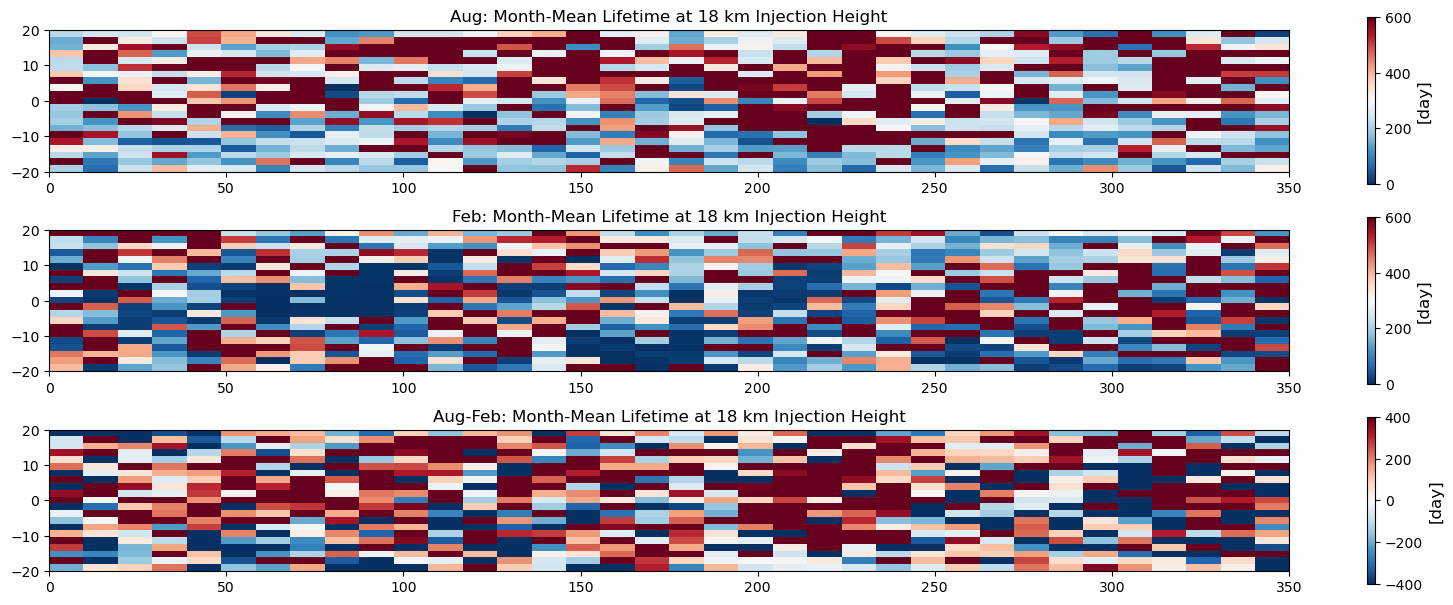

In [21]:
# One time data
# pixel plot: Aug vs. Feb, 18 km (75 hPa)
# lifetime[Nz, Ny, Nx, N_day, N_month, N_year]


lifetime_20km_y_x_08_mean = lifetime[1,:,:,1,9,2]
lifetime_20km_y_x_02_mean = lifetime[1,:,:,6,1,1]


fig = plt.figure(figsize=(20,7.5), dpi=100)
extent = [0 , 350 , -20 , 20]


#
ax1 = plt.subplot(3, 1, 1)
ax1_pixel = plt.imshow(lifetime_20km_y_x_08_mean, vmin=0, vmax=600,\
           extent = extent, cmap='RdBu_r', interpolation='nearest')

cb1 = plt.colorbar(ax1_pixel, ax=ax1)
cb1.set_label('[day]', fontsize=12);

ax1.set_title("Aug: Month-Mean Lifetime at 18 km Injection Height", fontsize=12);


#
ax2 = plt.subplot(3, 1, 2)
ax2_pixel = plt.imshow(lifetime_20km_y_x_02_mean, vmin=0, vmax=600,\
           extent = extent, cmap='RdBu_r', interpolation='nearest')

cb2 = plt.colorbar(ax2_pixel, ax=ax2)
cb2.set_label('[day]', fontsize=12);

ax2.set_title("Feb: Month-Mean Lifetime at 18 km Injection Height", fontsize=12);


#
ax3 = plt.subplot(3, 1, 3)
ax3_pixel = plt.imshow(lifetime_20km_y_x_08_mean-lifetime_20km_y_x_02_mean, vmin=-400, vmax=400,\
           extent = extent, cmap='RdBu_r', interpolation='nearest')

cb3 = plt.colorbar(ax3_pixel, ax=ax3)
cb3.set_label('[day]', fontsize=12);

ax3.set_title("Aug-Feb: Month-Mean Lifetime at 18 km Injection Height", fontsize=12);


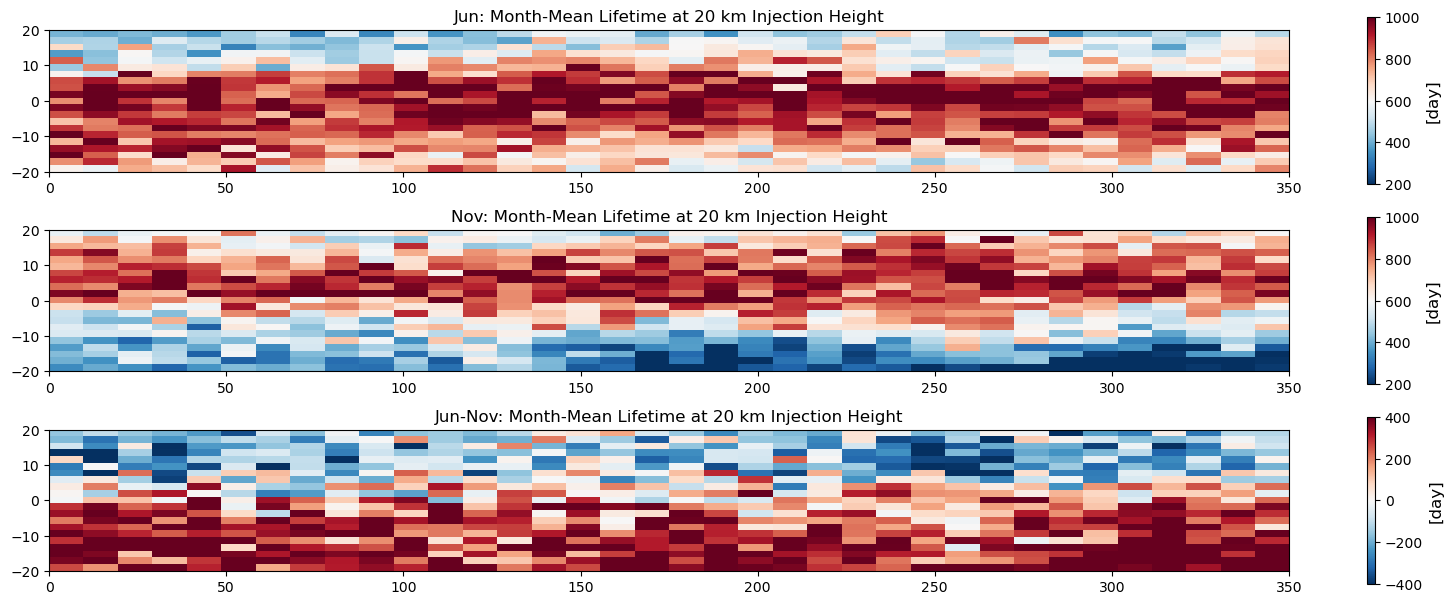

In [138]:
# pixel plot: Jun vs. Mar, 20 km (55 hPa)
# lifetime[Nz, Ny, Nx, N_day, N_month, N_year]


lifetime_z_y_x_mon_mean = np.mean(lifetime, axis=(3,5))

lifetime_20km_y_x_06_mean = lifetime_z_y_x_mon_mean[2,:,:,5]
lifetime_20km_y_x_11_mean = lifetime_z_y_x_mon_mean[2,:,:,10]


fig = plt.figure(figsize=(20,7.5), dpi=100)
extent = [0 , 350 , -20 , 20]


#
ax1 = plt.subplot(3, 1, 1)
ax1_pixel = plt.imshow(lifetime_20km_y_x_06_mean, vmin=200, vmax=1000,\
           extent = extent, cmap='RdBu_r', interpolation='nearest')

cb1 = plt.colorbar(ax1_pixel, ax=ax1)
cb1.set_label('[day]', fontsize=12);

ax1.set_title("Jun: Month-Mean Lifetime at 20 km Injection Height", fontsize=12);


#
ax2 = plt.subplot(3, 1, 2)
ax2_pixel = plt.imshow(lifetime_20km_y_x_11_mean, vmin=200, vmax=1000,\
           extent = extent, cmap='RdBu_r', interpolation='nearest')

cb2 = plt.colorbar(ax2_pixel, ax=ax2)
cb2.set_label('[day]', fontsize=12);

ax2.set_title("Nov: Month-Mean Lifetime at 20 km Injection Height", fontsize=12);


#
ax3 = plt.subplot(3, 1, 3)
ax3_pixel = plt.imshow(lifetime_20km_y_x_06_mean-lifetime_20km_y_x_11_mean, vmin=-400, vmax=400,\
           extent = extent, cmap='RdBu_r', interpolation='nearest')

cb3 = plt.colorbar(ax3_pixel, ax=ax3)
cb3.set_label('[day]', fontsize=12);

ax3.set_title("Jun-Nov: Month-Mean Lifetime at 20 km Injection Height", fontsize=12);


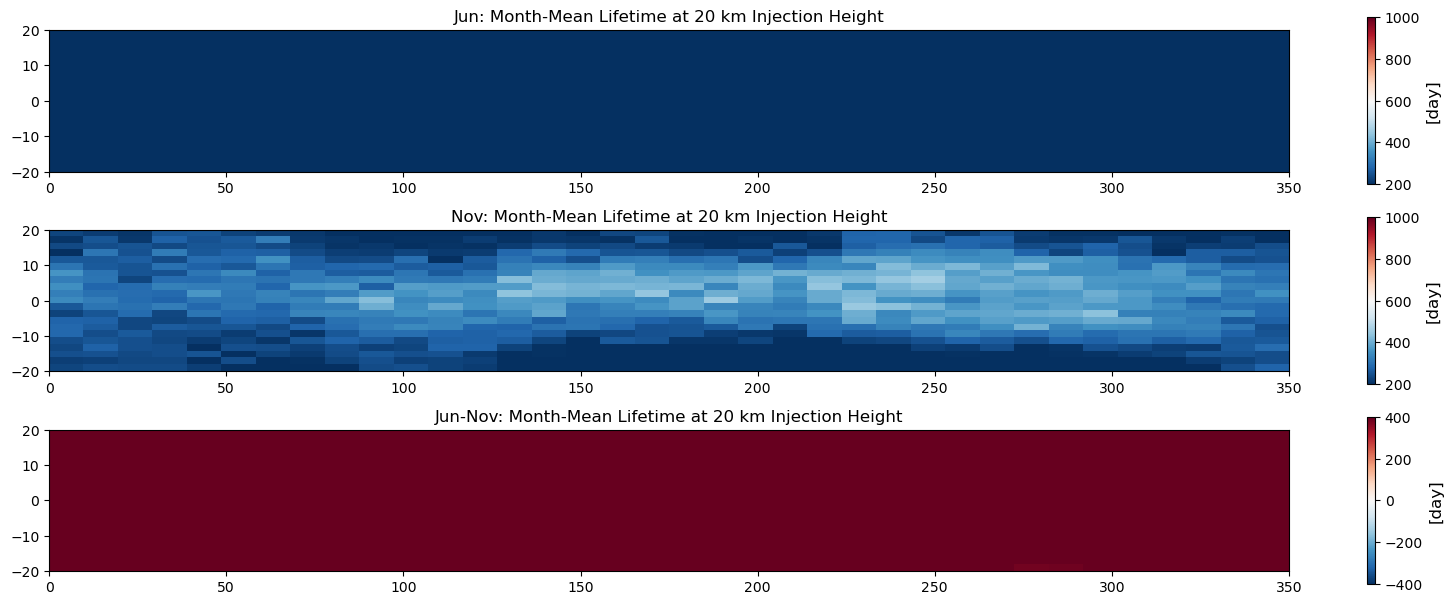

In [139]:
# pixel plot: Jun vs. Mar, 20 km (55 hPa)
# lifetime[Nz, Ny, Nx, N_day, N_month, N_year]


lifetime_z_y_x_mean = np.mean(lifetime, axis=(3,4,5))

lifetime_18km_y_x_mean = lifetime_z_y_x_mean[1,:,:]
lifetime_20km_y_x_mean = lifetime_z_y_x_mean[2,:,:]


fig = plt.figure(figsize=(20,7.5), dpi=100)
extent = [0 , 350 , -20 , 20]


#
ax1 = plt.subplot(3, 1, 1)
ax1_pixel = plt.imshow(lifetime_z_y_x_mean[0], vmin=200, vmax=1000,\
           extent = extent, cmap='RdBu_r', interpolation='nearest')

cb1 = plt.colorbar(ax1_pixel, ax=ax1)
cb1.set_label('[day]', fontsize=12);

ax1.set_title("Jun: Month-Mean Lifetime at 20 km Injection Height", fontsize=12);


#
ax2 = plt.subplot(3, 1, 2)
ax2_pixel = plt.imshow(lifetime_z_y_x_mean[1], vmin=200, vmax=1000,\
           extent = extent, cmap='RdBu_r', interpolation='nearest')

cb2 = plt.colorbar(ax2_pixel, ax=ax2)
cb2.set_label('[day]', fontsize=12);

ax2.set_title("Nov: Month-Mean Lifetime at 20 km Injection Height", fontsize=12);


#
ax3 = plt.subplot(3, 1, 3)
ax3_pixel = plt.imshow(lifetime_z_y_x_mean[2], vmin=-400, vmax=400,\
           extent = extent, cmap='RdBu_r', interpolation='nearest')

cb3 = plt.colorbar(ax3_pixel, ax=ax3)
cb3.set_label('[day]', fontsize=12);

ax3.set_title("Jun-Nov: Month-Mean Lifetime at 20 km Injection Height", fontsize=12);

In [140]:
# lifetime[Nz, Ny, Nx, N_day, N_month, N_year]

Life_xy = np.mean(lifetime[:,:,:,:,0,:], axis=(3,4)) # for Jan
print(Life_xy.shape)


(5, 21, 36)


AttributeError: 'list' object has no attribute 'BoundaryNorm'

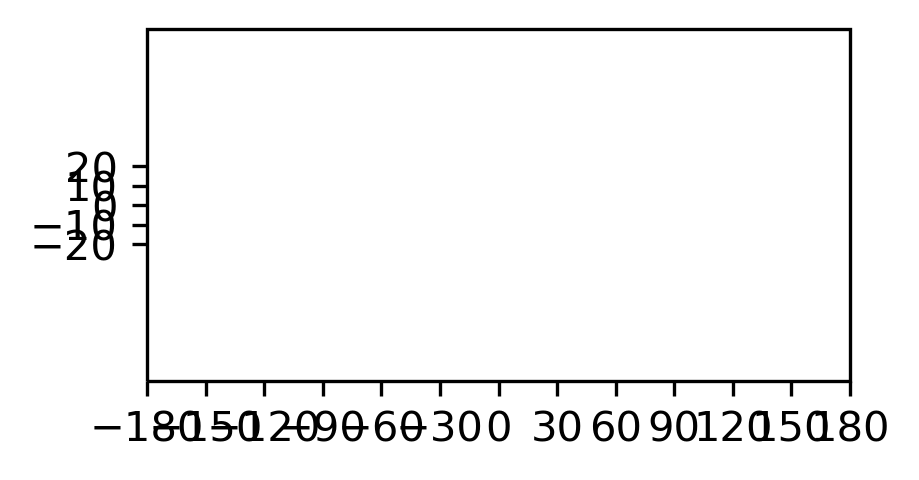

In [141]:
fig = plt.figure(figsize=(10,9), dpi=300);

projection=ccrs.PlateCarree()

# ax1
ax1 = plt.subplot(5, 1, 1, projection=ccrs.PlateCarree());
    
ax1.set_xticks(np.linspace(-180, 180, 13), crs=projection)
ax1.set_yticks(np.linspace(-20, 20, 5), crs=projection)

levels =  np.arange(100,1300,100)
norm = colors.BoundaryNorm(boundaries=levels, ncolors=256)

lat0 = Lats
lon0 = Lons
datas = Life_xy[0,:,:]

cyclic_datas = add_cyclic_point(datas)
datas, lon0_cyclic = add_cyclic_point(datas, coord=lon0)
    
ax1_contours = ax1.contourf(lon0_cyclic, lat0, datas, levels=levels, norm=norm,\
                                transform=ccrs.PlateCarree(), cmap=get_cmap("RdBu_r"), extend="max");
    
cb2 = plt.colorbar(ax1_contours, ax=ax1)
cb2.ax.tick_params(labelsize=11)
cb2.set_label('[day]', fontsize=12)
    
ax1.coastlines();
ax1.set_title('Lifetime at 100hPa', fontsize=13);
ax1.set_title('(b)', fontsize=13, loc='left');


# ax2
ax2 = plt.subplot(5, 1, 2, projection=ccrs.PlateCarree());
    
ax2.set_xticks(np.linspace(-180, 180, 13), crs=projection)
ax2.set_yticks(np.linspace(-20, 20, 5), crs=projection)

levels =  np.arange(600,1300,100)
norm = colors.BoundaryNorm(boundaries=levels, ncolors=256)

lat0 = Lats
lon0 = Lons
datas = Life_xy[1,:,:]

cyclic_datas = add_cyclic_point(datas)
datas, lon0_cyclic = add_cyclic_point(datas, coord=lon0)
    
ax2_contours = ax2.contourf(lon0_cyclic, lat0, datas, levels=levels, norm=norm,\
                                transform=ccrs.PlateCarree(), cmap=get_cmap("RdBu_r"), extend="max");
    
cb2 = plt.colorbar(ax2_contours, ax=ax2)
cb2.ax.tick_params(labelsize=11)
cb2.set_label('[day]', fontsize=12)
    
ax2.coastlines();
ax2.set_title('Lifetime at 70hPa', fontsize=13);
ax2.set_title('(b)', fontsize=13, loc='left');


# ax=3
ax3 = plt.subplot(5, 1, 3, projection=ccrs.PlateCarree());
    
ax3.set_xticks(np.linspace(-180, 180, 13), crs=projection)
ax3.set_yticks(np.linspace(-20, 20, 5), crs=projection)

levels =  np.arange(1000,1600,100)
norm = colors.BoundaryNorm(boundaries=levels, ncolors=256)

lat0 = Lats
lon0 = Lons
datas = Life_xy[2,:,:]
cyclic_datas = add_cyclic_point(datas)
datas, lon0_cyclic = add_cyclic_point(datas, coord=lon0)
    
ax3_contours = ax3.contourf(lon0_cyclic, lat0, datas, levels=levels, norm=norm,\
                                transform=ccrs.PlateCarree(), cmap=get_cmap("RdBu_r"), extend="max");
    
cb3 = plt.colorbar(ax3_contours, ax=ax3)
cb3.ax.tick_params(labelsize=11)
cb3.set_label('[day]', fontsize=12)
    
ax3.coastlines();
ax3.set_title('Lifetime at 50hPa', fontsize=13);
ax3.set_title('(c)', fontsize=13, loc='left');


# ax=4
ax4 = plt.subplot(5, 1, 4, projection=ccrs.PlateCarree());
    
ax4.set_xticks(np.linspace(-180, 180, 13), crs=projection)
ax4.set_yticks(np.linspace(-20, 20, 5), crs=projection)

levels =  np.arange(1000,1600,100)
norm = colors.BoundaryNorm(boundaries=levels, ncolors=256)

lat0 = Lats
lon0 = Lons
datas = Life_xy[3,:,:]
cyclic_datas = add_cyclic_point(datas)
datas, lon0_cyclic = add_cyclic_point(datas, coord=lon0)
    
ax4_contours = ax4.contourf(lon0_cyclic, lat0, datas, levels=levels, norm=norm,\
                                transform=ccrs.PlateCarree(), cmap=get_cmap("RdBu_r"), extend="max");
    
cb4 = plt.colorbar(ax4_contours, ax=ax4)
cb4.ax.tick_params(labelsize=11)
cb4.set_label('[day]', fontsize=12)
    
ax4.coastlines();
ax4.set_title('Lifetime at 40hPa', fontsize=13);
ax4.set_title('(d)', fontsize=13, loc='left');


# ax=5
ax5 = plt.subplot(5, 1, 5, projection=ccrs.PlateCarree());
    
ax5.set_xticks(np.linspace(-180, 180, 13), crs=projection)
ax5.set_yticks(np.linspace(-20, 20, 5), crs=projection)

levels =  np.arange(1200,1500,50)
norm = colors.BoundaryNorm(boundaries=levels, ncolors=256)

lat0 = Lats
lon0 = Lons
datas = Life_xy[4,:,:]
cyclic_datas = add_cyclic_point(datas)
datas, lon0_cyclic = add_cyclic_point(datas, coord=lon0)
    
ax5_contours = ax5.contourf(lon0_cyclic, lat0, datas, levels=levels, norm=norm,\
                                transform=ccrs.PlateCarree(), cmap=get_cmap("RdBu_r"), extend="max");
    
cb5 = plt.colorbar(ax5_contours, ax=ax5)
cb5.ax.tick_params(labelsize=11)
cb5.set_label('[day]', fontsize=12)
    
ax5.coastlines();
ax5.set_title('Lifetime at 25hPa', fontsize=13);
ax5.set_title('(e)', fontsize=13, loc='left');